In [48]:
import numpy as np
def jump(x, alpha=0, beta=0.5):
    one = lambda x: 1
    return np.where((x<beta) & (x>=alpha), one(x), 0.)

In [51]:
def picard_method(X, nx, nt, Tfinal, mu, theta):
    """theta picard method"""
    ### Parameters ###
    dx = (1-0)/(nx-1) 
    dt = (Tfinal-0)/(nt-1)
    C = 1*dt/(2*dx)
    D = mu*dt/(dx**2)
    
    ### Stability conditions ###
    if theta<0.5:
        a_1 = dx**2/(2*mu*(1-2*theta))
        a_2 = 2*mu/((1-2*theta))
        if dt>a_1:
            print("theta=",theta)
            print("error timestep too big")
            print("dt=",dt,"a_1=",a_1)    
        if dt>a_2:
            print("theta=",theta)
            print("error timestep too big")
            print("dt=",dt,"a_2=",a_2)
    
    ### warning ###
    if theta > 0:
        print("Warning, solving approximation to burgers")
    if theta == 0: 
        print("warning, inverting matrix unnessicarily")
    ### Initialise structure ###
    beta = np.zeros([nx])
    A = np.zeros([nx,nx])

    if theta >0:
        for i in range(0,nt-1):###time stepping###
        
            for j in range(0,nx): ### create vector on RHS###
                beta[j] = X[i,j]\
                - C*(1-theta)*X[i,j]*(X[i,(j+1)%nx] - X[i,(j-1)%nx])\
                + (D)*(1-theta)*(X[i,(j-1)%nx]-2*X[i,j]+X[i,(j+1)%nx])
        
            for p in range(0,nx): ### Create Matrix on LHS ###
                A[p,(p+1)%nx] =  theta*C*X[i,p] - theta*D # b 
                A[p,(p-1)%nx] = -theta*C*X[i,p] - theta*D  #c  
                A[p,p] = 1 + 2*theta*D
        
            X[i+1,:] = scipy.linalg.solve(A, beta)### Solving for next timestep ###
    if theta == 0: ## to avoid inverting a identity matrix pointlessly.
        for i in range(0,nt-1):###time stepping###
            for j in range(0,nx): ### create vector on RHS###
                beta[j] = X[i,j]\
                - C*(1-theta)*X[i,j]*(X[i,(j+1)%nx] - X[i,(j-1)%nx])\
                + (D)*(1-theta)*(X[i,(j-1)%nx]-2*X[i,j]+X[i,(j+1)%nx])

            X[i+1,:] = beta ### Solving for next timestep ###
    return X

In [52]:
def conservative_ftcs_method(X, nx, nt, Tfinal, mu):

    ## Parameters
    dx = (1-0)/(nx-1) 
    dt = (Tfinal-0)/(nt-1)
    C = 1*dt/(2*dx)
    D = mu*dt/(dx**2)
    a_1 = dx**2/(2*mu)
    a_2 = 2*mu/(1**2)
    
    
### needs stability criterion ###
### I am yet to do any but lax wendroff only useful for explicit case###
### when theta = 0 ###
    beta = np.zeros([nx])
    A = np.zeros([nx,nx])
    for i in range(0,nt-1):
        
        for j in range(0,nx): 
            beta[j] = X[i,j]\
            - C*0.5*(1)*(X[i,(j+1)%nx]**2 - X[i,(j-1)%nx]**2)\
            + (D)*(1)*(X[i,(j-1)%nx]-2*X[i,j]+X[i,(j+1)%nx])
    
        X[i+1,:] = beta
    return X

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from numpy.linalg import inv
import scipy.sparse

def newton_method(X, nx, nt, Tfinal, mu, theta):

    ### derived parameters ###
    dx = (1-0)/(nx-1) 
    dt = (Tfinal-0)/(nt-1)
    C = 1*dt/(2*dx)
    D = mu*dt/(dx**2)
    
    ##Creation of newton method structure 
    beta = np.zeros([nx])
    w = np.zeros([nx])
    dw = np.zeros([nx])

    for i in range(0,nt-1):### time loop 
        
        for j in range(0,nx): 
            w[j] = X[i,j] ### first initialise w^0 = phi^n as initial guess###
                          ### this is the starting guess for newton method ###
        
        ### Construct the newton loop
        tol = 10**(-13)## extreeme accuracy can be imposed
        err  = 2*tol
        while (err>tol): ### until convergence ###
            
            ### Create beta^k_j ###
            for q in range(0,nx): 
                beta[q] = X[i,q] - C*(1-theta)*X[i,q]*(X[i,(q+1)%nx] - X[i,(q-1)%nx]) + (D)*(1-theta)*(X[i,(q-1)%nx]-2*X[i,q]+X[i,(q+1)%nx]) \
                -w[q] - C*theta*w[q]*(w[(q+1)%nx]-w[(q-1)%nx]) + D*theta*(w[(q+1)%nx]-2*w[q] +w[(q-1)%nx])
            
            ##Create A^k_j ###
            A = np.zeros([nx,nx])
            for p in range(1,nx):
                A[p-1,p] = ((theta*C*w[p])-(theta*D)) # b
            for p in range(0,nx-1):
                A[p+1,p] = ((-theta*C*w[p+1])-(theta*D)) # c
            for p in range(0,nx):
                A[p,p] = (1+ 2*theta*D + C*theta*(w[(p+1)%nx]-w[(p-1)%nx]))
            
            
            ## solving for dw
            dw = scipy.linalg.solve(A, beta)
            err = np.linalg.norm(dw,2)
            ## improve the newton loop
            w = w + dw 
            ## we have w^k
            
    
        
        for j in range(0,nx):
            X[i+1,j] = w[j]


    return X 
    



In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from numpy.linalg import inv
import scipy.sparse

def conservative_newton_method(X, nx, nt, Tfinal, mu, theta):
    ##derived constants
    dx = (1-0)/(nx-1) ##
    dt = (Tfinal-0)/(nt-1)
    ## Parameters
    C = 1*dt/(2*dx)
    D = mu*dt/(dx**2)
    ##

    ##Construction of the vector per timestep ie beta note for inversion we only want the 
    beta = np.zeros([nx])
    w = np.zeros([nx])
    dw = np.zeros([nx])

    for i in range(0,nt-1):### time loop 
        ## first initialise w^0 = phi^n
        for j in range(0,nx): 
            w[j] = X[i,j]

        ### Construct the newton loop
        tol = 10**(-13) ### accuracy can be imposed ###
        err  = 2*tol
        while (err>tol): ## eventually replace with while loop and stopping criterion

            ### Create beta^k ###
            for q in range(0,nx): 
                beta[q] = X[i,q] - C*0.5*(1-theta)*(X[i,(q+1)%nx]**2 - X[i,(q-1)%nx]**2) \
                + (D)*(1-theta)*(X[i,(q-1)%nx]-2*X[i,q]+X[i,(q+1)%nx]) \
                -w[q] - C*0.5*theta*(w[(q+1)%nx]**2-w[(q-1)%nx]**2) \
                + D*theta*(w[(q+1)%nx]-2*w[q] +w[(q-1)%nx])
            
            ### Create A^k_j, tridiag ###
            A = np.zeros([nx,nx])
            for p in range(1,nx):
                A[p-1,p] = ((theta*C*w[(p+1)%nx])-(theta*D)) # down zero across 1 = b
            for p in range(0,nx-1):
                A[p+1,p] = ((-theta*C*w[(p-1)%nx])-(theta*D)) # down 1 acros 0 = c
            for p in range(0,nx):
                A[p,p] = (1+ 2*theta*D + C*theta*(w[(p+1)%nx]-w[(p-1)%nx]))
        
            ## solving for dw
            dw = scipy.linalg.solve(A, beta)
            err = np.linalg.norm(dw,2)
            ## improve the newton loop
            w = w + dw 
            ## we have w^k
            
        
        for j in range(0,nx):
            X[i+1,j] = w[j]

    return X 
    



In [55]:
import numpy as np
import math as math
import matplotlib.pyplot as plt

def SolveBurger(nx ,nt ,Tfinal ,mu, method, theta ):
    """SOLVES BURGERS EQUATION: u_t + u(u_x) - mu u_{xx} = 0 NUMERICALLY
                                u_t + (u^2/2)_x - mu u_{xx} = 0 Conservative form
       nx = number of space points
       nt = number of time points 
       Tfinal = the final time  
       mu = the viscosity in the burgers equation 
       
       method = input:=  "picard" SOLVES APPROXIMATION TO BURGERS EQUATION
                         "newton" SOLVES EXACT BURGERS EQUATION
                         "conservative_ftcs" SOLVES CONSERVATIVE FORM USING EXPLICIT METHOD
                         "conservatice_newton" SOLVES CONSERVATIVE FORM USING NEWTONS METHOD
       theta = 1 is implicit,
               0 is explicit """
    ##derived constants
    x = np.linspace(0,1,nx)
    dx = (1-0)/(nx-1) ##
    t = np.linspace(0,Tfinal,nt)
    dt = (Tfinal-0)/(nt-1)
    c = 1*(dt/dx)
    d = mu*(dt*1/(dx**2))
    
    ##**Creating the structure**## 
    X = np.zeros( [nt,nx] )##**Each row contains a timestep**##
    
    ### Initialisation of BC ###
    X[0,:] = jump(x, 0.1, 0.3)

### Timestepping the whole scheme 
    if method == "newton":
        newton_method(X, nx, nt, Tfinal, mu, theta)
    if method == "picard":
        picard_method(X, nx, nt, Tfinal, mu, theta)
    if method == "conservative_ftcs":
        conservative_ftcs_method(X, nx, nt, Tfinal, mu)
    if method == "conservative_newton":
        conservative_newton_method(X, nx, nt, Tfinal, mu, theta)
 
    return X

def Plotting(X,nx,nt):
### Extraction of time steps for plotting ###
    x = np.linspace(0,1,nx)
    y = X[0,:]
    plt.plot(x,y,'r')
    y = X[nt-1,:]
    plt.plot(x, y,'b',linewidth=0.5)
### not exactly user friendly ###

In [56]:
# analytical solution ## incomplete
### Do I need to compute against a analytical solution?
help(SolveBurger)

Help on function SolveBurger in module __main__:

SolveBurger(nx, nt, Tfinal, mu, method, theta)
    SOLVES BURGERS EQUATION: u_t + u(u_x) - mu u_{xx} = 0 NUMERICALLY
                             u_t + (u^2/2)_x - mu u_{xx} = 0 Conservative form
    nx = number of space points
    nt = number of time points 
    Tfinal = the final time  
    mu = the viscosity in the burgers equation 
    
    method = input:=  "picard" SOLVES APPROXIMATION TO BURGERS EQUATION
                      "newton" SOLVES EXACT BURGERS EQUATION
                      "conservative_ftcs" SOLVES CONSERVATIVE FORM USING EXPLICIT METHOD
                      "conservatice_newton" SOLVES CONSERVATIVE FORM USING NEWTONS METHOD
    theta = 1 is implicit,
            0 is explicit



Warning, solving approximation to burgers


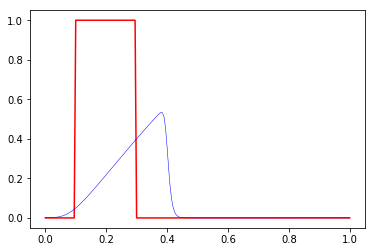

In [57]:
X = SolveBurger(201,15,0.5,0.001,"picard",1)
Plotting(X,201,15)
## the scheme for theta=1 converges even for few large timesteps.
## however the equation solved is inaccurate, it isnt the correct eqaution.

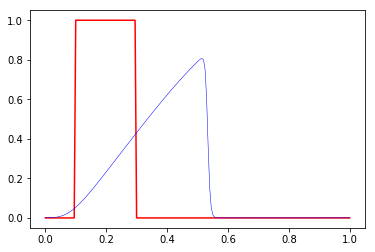

In [58]:
X = SolveBurger(201,51,0.5,0.001,"newton",1)
Plotting(X,201,51)
## there is a timestep restriction independent of the timestep condition.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.000089e-24
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.387466e-44
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.472776e-64
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.173169e-87
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/sit

ValueError: array must not contain infs or NaNs

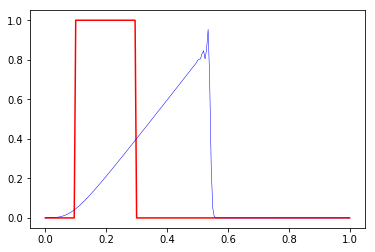

In [59]:
X = SolveBurger(201,201,0.5,0.001,"conservative_newton",0)
Plotting(X,201,201)
X = SolveBurger(201,51,0.5,0.001,"conservative_newton",1)
Plotting(X,201,51)
### the ball of convergence depends on the value of theta, fully implicit is the

In [ ]:
X = SolveBurger(201,151,0.5,0.001,"conservative_ftcs",0) 
Plotting(X,201,151)

In [ ]:
X = SolveBurger(101,201,0.5,0.001,"conservative_newton",1)
Y = SolveBurger(101,201,0.5,0.001,"newton",1)
C = X-Y
D = 0.5*(X+Y)
plt.figure(1)
Plotting(C,101,201)
plt.figure(2)
Plotting(X,101,201)
Plotting(Y,101,201)

In [60]:
#•Stability analysis for theta = 0 cases remembering whether vonn neuman annalisis works

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily
warning, inverting matrix unnessicarily


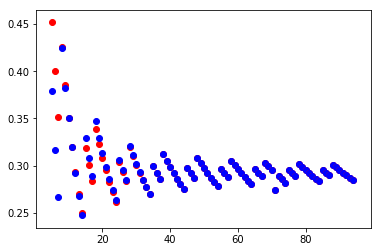

In [61]:
#analysis for increasing spatial resolution at a further timestep
w = 500
plt.figure(1)
nx = 1*w+11
nt = 601
AA = SolveBurger(nx,nt,0.5,0.01,"conservative_ftcs",0)
vec = AA[nt-1,:]
yy = np.linalg.norm(vec,2)/nx**0.5
y = np.linspace(0,1,100)
y[:] = yy
plt.plot(y)

for w in range(90):
    plt.figure(1)
    nx = 1*w+5
    nt = 601
    AA = SolveBurger(nx,nt,0.5,0.01,"conservative_ftcs",0)
    vec = AA[nt-1,:]
    yy = np.linalg.norm(vec,2)/nx**0.5
    plt.scatter(nx,yy,color='red')
    plt.figure(1)
    nx = 1*w+5
    nt = 601
    AA = SolveBurger(nx,nt,0.5,0.01,"picard",0)
    vec = AA[nt-1,:]
    yy = np.linalg.norm(vec,2)/nx**0.5
    plt.scatter(nx,yy,color='blue')
### can i see quadratic convergence in space up until gibbslike 
###phenomena dominate? ###

### REAL PROBLEM ###
### higher spatial discretisation increases cost of implicit methods
### so explicit may actually be the way to go... 

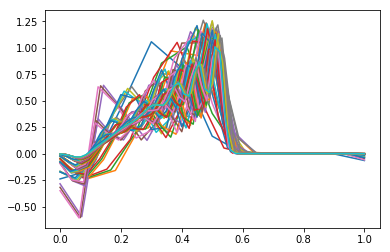

In [43]:
for w in range(50):
    nx = 1*w+11
    x = np.linspace(0,1,nx)
    nt = 601
    AA = SolveBurger(nx,nt,0.5,0.001,"conservative_ftcs",0)
    vec = AA[nt-1,:]
    plt.plot(x,vec)
    
### We have the effect of spatial discretisation on the final time-step